## Project 9 Part 2 - Airbnb Rent Price Prediction

### Notebook Content

1. Model training and evaluation
2. Bayesian Optimization results analysis


## 1. Model training and evaluation
---

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
    
from skopt import BayesSearchCV

from skopt.plots import (plot_convergence, plot_evaluations, plot_objective)
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

Import dataset:

In [5]:
train = pd.read_csv('datasets/ds_train_v2.csv')
test = pd.read_csv('datasets/ds_test_v2.csv')

In [6]:
X_train = train.drop(columns='price')            
y_train = train['price']
X_test = test.drop(columns='price')            
y_test = test['price']

In [7]:
print('X_train shape: {}, type: {}'.format(X_train.shape, type(X_train)))
print('y_train shape: {}, type: {}'.format(y_train.shape,type(y_train)))
print('X_test shape: {}, type: {}'.format(X_test.shape,type(X_test)))
print('y_test shape: {}, type: {}'.format(y_test.shape,type(y_test)))

X_train shape: (24426, 23), type: <class 'pandas.core.frame.DataFrame'>
y_train shape: (24426,), type: <class 'pandas.core.series.Series'>
X_test shape: (6134, 23), type: <class 'pandas.core.frame.DataFrame'>
y_test shape: (6134,), type: <class 'pandas.core.series.Series'>


## Model - GBM with Bayesian Optimization with Scikit-Optimize  


Model definition:

In [8]:
gbm = GradientBoostingRegressor(random_state=42)

Hyperparameter space:

In [9]:
param_grid = {
              'n_estimators': (10, 120),     
              'min_samples_split': (0.001, 0.99, 'log-uniform'),
              'max_depth': (1, 8),            
              'loss': ['ls', 'lad', 'huber'],
              'learning_rate': (0.01, 0.99, 'log-uniform')
             }

Bayesian Optimization:



In [11]:
model_gbm = BayesSearchCV(estimator=gbm,             
                          search_spaces=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          n_iter=50, 
                          random_state=42,
                          n_jobs=-1,
                          refit=True
                          )

In [12]:
model_gbm.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
              n_jobs=-1, random_state=42, scoring='neg_mean_squared_error',
              search_spaces={'learning_rate': (0.01, 0.99, 'log-uniform'),
                             'loss': ['ls', 'lad', 'huber'],
                             'max_depth': (1, 8),
                             'min_samples_split': (0.001, 0.99, 'log-uniform'),
                             'n_estimators': (10, 120)})

## 2. Bayesian Optimization results analysis 
---

Best model hyperparameters:

In [13]:
model_gbm.best_params_

OrderedDict([('learning_rate', 0.1490202161854594),
             ('loss', 'huber'),
             ('max_depth', 7),
             ('min_samples_split', 0.0244450727526552),
             ('n_estimators', 102)])

Lower mse score:

In [14]:
model_gbm.best_score_

-1557.49643661251

Different evaluated models results:

In [15]:
results = pd.DataFrame(model_gbm.cv_results_)
print(results.shape)
results.head()

(50, 18)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.269818,0.121445,0.016904,0.008017,0.065829,lad,8,0.008831,84,"{'learning_rate': 0.06582909638806708, 'loss':...",-1565.066072,-1648.351533,-1647.752819,-1594.660930,-1631.359643,-1617.438199,32.649841,35
1,1.724160,0.049129,0.006206,0.000400,0.468945,ls,3,0.707163,105,"{'learning_rate': 0.46894474540415176, 'loss':...",-1619.189981,-1713.531773,-1697.817588,-1698.131954,-1732.194765,-1692.173212,38.605260,40
2,0.505062,0.010610,0.009376,0.007655,0.077219,ls,2,0.019866,31,"{'learning_rate': 0.07721886560160725, 'loss':...",-1966.620662,-2032.511910,-2074.055154,-2001.335391,-2039.577362,-2022.820096,36.386089,49
3,2.626979,0.030356,0.003125,0.006250,0.418067,huber,5,0.253975,68,"{'learning_rate': 0.41806713315569055, 'loss':...",-1528.254730,-1632.052799,-1634.371602,-1613.413741,-1629.583214,-1607.535217,40.317168,30
4,4.533502,0.083970,0.011730,0.005553,0.39411,lad,5,0.139321,109,"{'learning_rate': 0.3941095765751702, 'loss': ...",-1557.822147,-1654.717159,-1646.839233,-1624.641017,-1671.390893,-1631.082090,39.598511,37


Different models results ordered by performance:

Text(0.5, 0, 'Hyperparameter combinations')

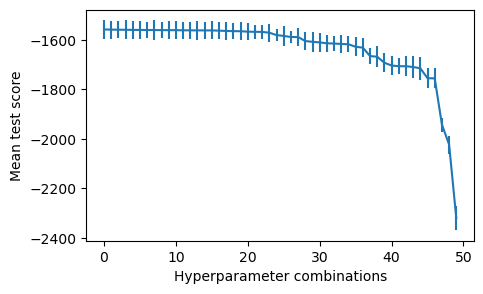

In [16]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)

plt.figure(figsize=(5,3))
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

**Figure 1.** Results for different hyperparameters combinations.

Model results:

In [17]:
X_train_preds = model_gbm.predict(X_train)
X_test_preds = model_gbm.predict(X_test)

print('Train rmse: ', np.sqrt(mean_squared_error(y_train, X_train_preds)))
print('Test rmse: ', np.sqrt(mean_squared_error(y_test, X_test_preds)))

Train rmse:  36.35946984807214
Test rmse:  39.21687868023874


Search convergence evaluation:

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

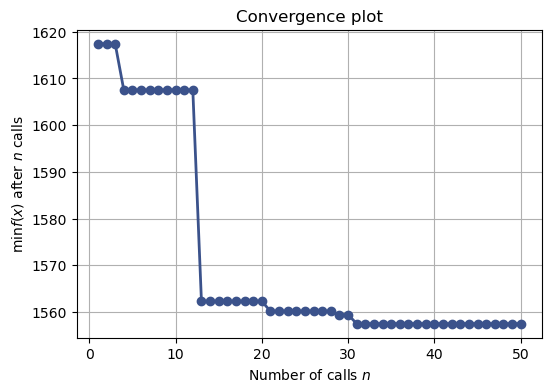

In [21]:
plt.figure(figsize = (6,4))
plot_convergence(model_gbm.optimizer_results_[0])

**Figure 2.** Models results for successive calls showing the bayesian search evolution.

We can see the model stabilizes after 31 rounds.

Partial dependence plots:

In [38]:
dims = ['n_estimators', 'min_samples_split', 'max_depth', 'loss', 'learning_rate']

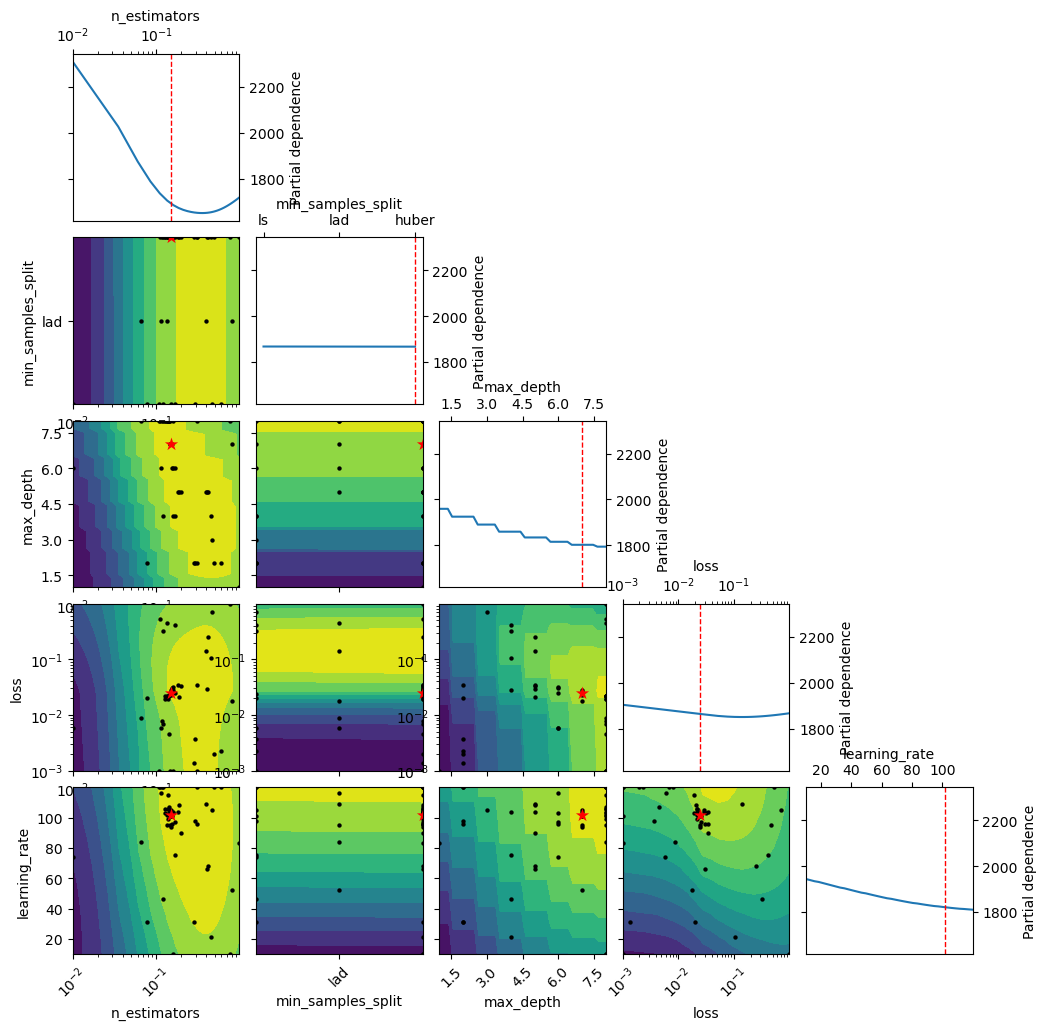

<Figure size 500x500 with 0 Axes>

In [37]:
_ = plot_objective(model_gbm.optimizer_results_[0],
                   dimensions=dims,
                   n_minimum_search=int(1e8)
                  )
plt.show()                                   

**Figure 3.** Partial Dependence plots of the objective function. The red star is the best value for the given hyperparameter.

Evaluation order:

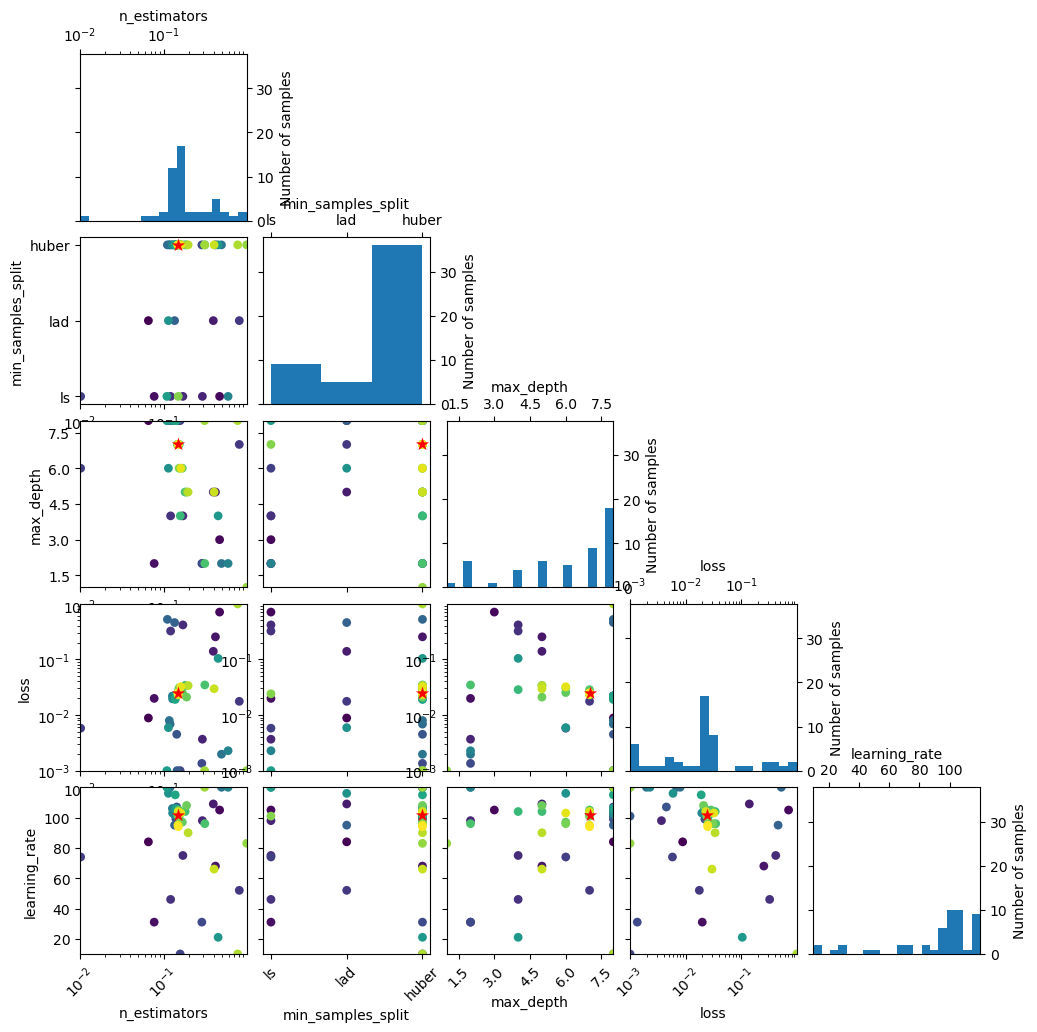

In [39]:
_ = plot_evaluations(model_1.optimizer_results_[0],
                     dimensions=dims,
                     )
plt.show()   

**Figure 4.** Color encoded order in which points were sampled during optimization. The red star is the best value for the given hyperparameter.